# Recomendações cervejeiras.

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

df = pd.read_csv('data/user_interactions.csv')
df_beer = pd.read_csv('data/clean_beers.csv')
del df['Unnamed: 0']
del df_beer['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,product_id,order_id,user_id
0,2187,2310942933416673977,8147
1,2059,2316136337087922698,8642
2,2057,2316746918924911613,8563
3,2133,2316899056305045560,9990
4,1988,2317477536566608607,9437


In [20]:
print(df_beer.shape)
df_beer.head()

(2410, 6)


,abv,ibu,id,name,style,ounces
0,0.050,NaN,1223,Pub Beer,American Pale Lager,12.0
1,0.066,NaN,423,Devil's Cup,American Pale Ale (APA),12.0
2,0.071,NaN,424,Rise of the Phoenix,American IPA,12.0
3,0.090,NaN,425,Sinister,American Double / Imperial IPA,12.0
4,0.075,NaN,426,Sex and Candy,American IPA,12.0


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

In [21]:
df["user_id"].value_counts().describe()

count    10256.000000
mean         2.744150
std          6.529046
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        123.000000
Name: user_id, dtype: float64

<AxesSubplot:>

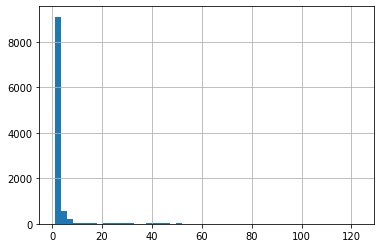

In [22]:
df["user_id"].value_counts().hist(bins = 50)

In [23]:
df_beer[df_beer.duplicated("id")]

,abv,ibu,id,name,style,ounces


In [24]:
print(f"Cervejas com ao menos uma compra {df['product_id'].unique().shape[0]}") 
print(f"Total de Cervejas cadastradas {df_beer.shape[0]}")
print(f"Usuários unicos {df['user_id'].value_counts().shape[0]}")
print(f"Total de compras feitas {df.shape[0]}")

Cervejas com ao menos uma compra 2409
Total de Cervejas cadastradas 2410
Usuários unicos 10256
Total de compras feitas 28144


In [25]:
most_bought_beer_id = df.product_id.value_counts().index.to_list()[0]
most_bought_beer = df_beer.loc[df_beer['id'] == most_bought_beer_id].iloc[0]["name"]

print(f"A cerveja mais comprada foi {most_bought_beer}")
print(f"Com {df['product_id'].value_counts().max()} compras")

A cerveja mais comprada foi People's Pilsner
Com 601 compras


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>


TOP N cerveja mais compradas

In [26]:
df_beer.name

0                   Pub Beer
1                Devil's Cup
2        Rise of the Phoenix
3                   Sinister
4              Sex and Candy
                ...         
2405               Belgorado
2406           Rail Yard Ale
2407         B3K Black Lager
2408     Silverback Pale Ale
2409    Rail Yard Ale (2009)
Name: name, Length: 2410, dtype: object

In [30]:
n = 10

ids = df.product_id.value_counts().head(n).index.to_list()
print(ids)

top_beers = [df_beer.loc[df_beer.id == i].iloc[0]['name'] for i in ids]
#2692
top_beers

[874, 1079, 424, 626, 296, 1399, 1096, 1098, 1986, 1871]


["People's Pilsner",
 'Seven Gates Pale Ale',
 'Rise of the Phoenix',
 'Fear of a Brett Planet',
 'Nonstop Hef Hop',
 "JP's Ould Sod Irish Red IPA",
 'Lemon Shandy Tripel',
 'Killer Whale Cream Ale',
 "Mountain Livin' Pale Ale",
 "Dale's Pale Ale (2003)"]

In [35]:
def get_top_beers_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top beers to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' beers ids 
    '''
    
    top_beers_ids = df.product_id.value_counts().head(n).index.to_list()
    
    return top_beers_ids 

def get_top_beers(n, df=df_beer):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    '''
    
    top_beers_ids = get_top_beers_ids(n)
    
    top_beers = [
        df_beer.loc[df_beer.id == i].iloc[0]['name'] 
        for i in top_beers_ids
    ]
    
    return top_beers

In [36]:
get_top_beers_ids(10)
get_top_beers(10)

["People's Pilsner",
 'Seven Gates Pale Ale',
 'Rise of the Phoenix',
 'Fear of a Brett Planet',
 'Nonstop Hef Hop',
 "JP's Ould Sod Irish Red IPA",
 'Lemon Shandy Tripel',
 'Killer Whale Cream Ale',
 "Mountain Livin' Pale Ale",
 "Dale's Pale Ale (2003)"]

Então caso um usuário seja novo na aplicação e não tenhamos um a triagem inicial, uma "boa" opção é a recomendação de uma das mais populares.

### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


In [46]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with user_id, order_id, product_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and product ids on the columns with 1 values where a user puchase a beer
    and a 0 otherwise
    '''
    
    nan_matrix = df.groupby(['user_id', 'product_id'])['order_id'].count().unstack()
    user_item = nan_matrix.notnull().astype(int) 
    
    return user_item  


In [47]:
user_item = create_user_item_matrix(df)
print(user_item.shape)
user_item

(10256, 2409)


product_id,1,2,3,4,5,6,7,8,9,10,...,2400,2401,2402,2403,2404,2405,2406,2407,2408,2409
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10252,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10253,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10254,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by beers: 
                1's when a user has interacted with an beer, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    similarity = user_item.dot(user_item.loc[user_id])
    
    # sort by similarity
    similarity = similarity.sort_values(ascending=False)
    # create list of just the ids
    most_similar_users = similarity.index.to_list()
    # remove the own user's id
    most_similar_users.remove(user_id)
    
    return most_similar_users # return a list of the users in order from most to least similar

In [66]:
find_similar_users(171)[:10]

[934, 38, 175, 178, 45, 169, 96, 513, 235, 236]

In [93]:
def get_beer_names(beers_ids, df_beer=df_beer):
    '''
    INPUT:
    beers_ids - (list) a list of beer ids
    df_beer - (pandas dataframe) df as defined at the top of the notebook
    
    
    OUTPUT:
    beers_names - (list) a list of beers names associated with the list of beers ids 
                  (this is identified by the title column)
    '''
    
    beers_names = [df_beer.loc[df_beer.id == int(i)].iloc[0]["name"] for i in beers_ids]
    
    return beers_names 


def get_user_beers(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by beers: 
                1's when a user has interacted with an beer, 0 otherwise
    
    OUTPUT:
    beers_ids - (list) a list of the beer ids seen by the user
    beers_names - (list) a list of beer names associated with the list of beer ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the product_ids and beers names that have been seen by a user
    '''
    user_beers = user_item.loc[user_id]

    beers_ids = []
    for i, x in zip(user_beers.index, user_beers):
        if x:
            beers_ids.append(str(i))
            
    
    beer_names = get_beer_names(beers_ids)
    
    return beers_ids, beer_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds beers the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended beers starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    
    similar_users = find_similar_users(user_id)
    
    user_beer_ids, user_beer_names = get_user_beers(user_id)
    
    recs = []
    for user in similar_users:
        beer_ids, beer_names = get_user_beers(user)
        
        for i in beer_ids:
            if(i not in user_beer_ids and i not in recs):
                recs.append(i)
                if len(recs) >= m:
                    return recs
                
    return recs # return your recommendations for this user_id  

In [94]:
# Check Results
get_beer_names(user_user_recs(171, 10)) # Return 10 recommendations for user 171

['Misty Mountain Hop',
 'One-Hit Wonderful',
 'Alter Ego ',
 'Oktoberfest',
 'Straub Beer (Current)',
 'Lighthouse Amber',
 'Behemoth',
 'Pretzel Stout',
 "Devil's Cup",
 'Rise of the Phoenix']

### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

Pontos de atenção:
-> Usuário consumir um produto uma vez, ou 100 vezes tem o mesmo peso para o modelo